# Сопоставление фотографий керна

* [Задача](#Задача)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Валидация](#Валидация)

## Задача

Найти пары фотографий керна в дневном и ультрафиолетовом свете, которые не соответствуют друг другу (смещены, перевернуты, растянуты и пр.)

## Датасет

В датасет включены данные по трем скважинам. Каждая скважина представлена набором снимков керна в дневном и ультрафиолетовом свете, а также разметка пар снимков. Пары без дефектов отмечены 1, с дефектами - 0.

Пример хорошей пары:

In [1]:
from utils import *

plot_pair('/notebooks/data/processed_dataset/417по', '417по_2356.58_2357.56.png')

<Figure size 500x1500 with 2 Axes>

Пример плохой пары:

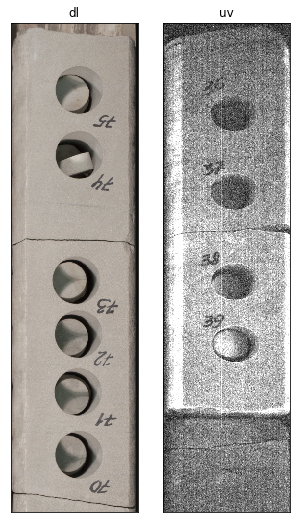

In [2]:
plot_pair('/notebooks/data/processed_dataset/417по', '417по_2360.6_2361.35.png')

Для решения задачи был написан `CoreBatch` с загрузчиком данных и необходимыми аугментациями.

In [3]:
import os
import sys
import glob

from PIL import Image

sys.path.insert(0, os.path.join("..", "..", ".."))

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from well_logs import CoreBatch, CoreIndex
from well_logs.batchflow import Dataset, Pipeline, B, V, FilesIndex
from well_logs.batchflow.models.torch import ResNet18

In [4]:
PATH = '/notebooks/data/processed_dataset/*'

index = CoreIndex(path=os.path.join(PATH, 'samples_dl/*.png'))

## Предобработка данных

Загрузим файл с разметкой и обратим метки: теперь 1 соответствует плохой паре

In [5]:
df = read_annotation(PATH, df_name='samples.feather')

Удалим из индекса все плохие пары, чтобы использовать только хорошие и их аугментированные варианты.

In [6]:
index = index.create_subset(np.intersect1d(df.index.values[df['QC'] == 0], index.indices))
ds = Dataset(index, CoreBatch)
ds.split(shuffle=42)

Обучение будем производить на кропах следующего размера:

In [7]:
SHAPE = (2, 600, 150)

## Архитектура

Для предсказания будем использовать ResNet18 в базовом варианте

# Обучение

In [8]:
BATCH_SIZE = 32
N_EPOCH = 100

model_config = {'initial_block/inputs': 'images',
                'inputs/images/shape': SHAPE,
                'inputs/labels/classes': 2,
                'initial_block/inputs': 'images',
                'optimizer': 'Adam',
                'output': 'proba',
                'device': 'gpu:0',
                'loss': 'ce'}

При обучении будем использовать два типа аугментаций: отражение изображений по горизонтали и перемешивание фотографий, поскольку это два наиболее частых и плохих дефекта изображений. Также переведем изображения в ч/б.

In [9]:
# bounds = get_bounds(PATH, percentile=80)

In [10]:
bounds = {'215по': {'dl': 158.0, 'uv': 36.0},
 '3237': {'dl': 161.0, 'uv': 54.0},
 '3311': {'dl': 160.0, 'uv': 30.0},
 '417по': {'dl': 175.0, 'uv': 20.0},
 '4283': {'dl': 161.0, 'uv': 35.0},
 '509': {'dl': 177.0, 'uv': 19.0},
 '604': {'dl': 191.0, 'uv': 48.0},
 '611': {'dl': 168.0, 'uv': 27.0},
 '1по': {'dl': 139.0, 'uv': 5.0},
 '2по': {'dl': 143.0, 'uv': 29.0},
 '3по': {'dl': 128.0, 'uv': 34.0},
 '8по': {'dl': 126.0, 'uv': 7.0}}

In [11]:
load_ppl = (Pipeline()
    .load(grayscale=True)
    .normalize()
    .fix_shape()
    .resize(size=(SHAPE[2], None), src='dl', dst='dl')
    .resize(size=(SHAPE[2], None), src='uv', dst='uv')
    .mirror_padding((SHAPE[2], SHAPE[1]))
)

with Pipeline() as p:
    augmentation_ppl = p.flip(proba=0.3) + p.shuffle(proba=0.3)

In [12]:
train_template = (Pipeline()
    .to_array(src='uv', dst='uv', channels='first')
    .to_array(src='dl', dst='dl', channels='first')
    .random_crop(shape=SHAPE[1:], proba=0)
     .init_model('dynamic', ResNet18, 'model', model_config)
     .init_variable('loss', init_on_each_run=list)
     .concatenate(dst='images')
     .train_model('model', B('images'), B('labels'), fetches='loss',
                 save_to=V('loss', mode='a'))
     .run(
        batch_size=BATCH_SIZE,
        n_epochs=N_EPOCH,
        shuffle=True,
        drop_last=True,
        lazy=True,
        bar=True
    )
)

In [13]:
train_ppl = (load_ppl + augmentation_ppl + train_template) << ds.train

In [14]:
train_ppl.run()
train_ppl.get_model_by_name('model').save('resnet16.torch')

with open('loss', 'wb') as f:
    pickle.dump(train_ppl.get_variable('loss'), f)

with open('dataset', 'wb') as f:
    pickle.dump(ds, f)

100%|██████████| 2300/2300 [35:54<00:00,  1.02it/s]


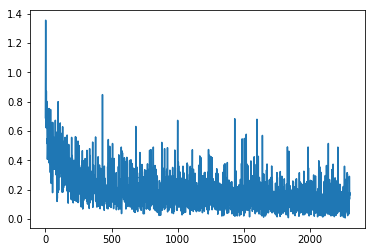

In [15]:
with open('loss', 'rb') as f:
    loss = pickle.load(f)
    
with open('dataset', 'rb') as f:
    ds = pickle.load(f)

plt.plot(loss)
plt.show()

## Валидация

Сначала провалидируемся на кропах

In [16]:
test_template = (Pipeline()
     .to_array(src='uv', dst='uv', channels='first')
     .to_array(src='dl', dst='dl', channels='first')
     .random_crop(SHAPE[1:], proba=0)
     .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:1', 'load/path': 'resnet16.torch'
                })
     .init_variable('loss', init_on_each_run=list)
     .concatenate(dst='images')
     .init_variable('proba', init_on_each_run=None)
     .init_variable('metrics', init_on_each_run=None)
     .predict_model('model', B('images'), targets=B('labels'), fetches='proba', save_to=B('proba', mode='w'))
     .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                     fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
     .run(
        batch_size=BATCH_SIZE,
        n_epochs=10,
        shuffle=True,
        drop_last=False,
        lazy=True,
        bar=False
    )
)

In [17]:
test_ppl = (load_ppl + augmentation_ppl + test_template) << ds.test

Посмотрим на примеры предсказаний

2по_2по_2392_2392.92.png
Label:  0.0   Prediction:0.00035121056


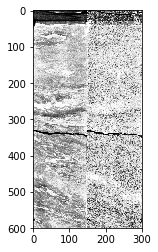

2по_2по_2316_2317.png
Label:  1.0   Prediction:0.97314453


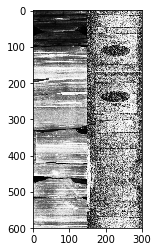

417по_417по_3008.3_3009.12.png
Label:  0.0   Prediction:0.08055126


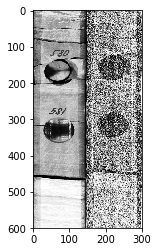

2по_2по_2790_2791.png
Label:  0.0   Prediction:8.516503e-06


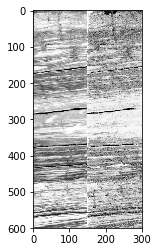

3по_3по_2843_2844.png
Label:  0.0   Prediction:7.7455334e-05


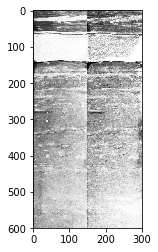

In [18]:
batch = test_ppl.next_batch()
plot_crops_predictions(batch)

In [19]:
test_ppl.reset_iter()
test_ppl.run()

metrics = test_ppl.get_variable('metrics')
print(metrics._confusion_matrix)

for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

[[[874  40]
  [ 76 900]]]
specificity : 0.92
sensitivity : 0.9574468085106383
accuracy : 0.9386243386243386


# Провалидируемся на целых изображениях

In [20]:
test_template = (Pipeline()
    .to_array(src='uv', dst='uv', channels='first')
    .to_array(src='dl', dst='dl', channels='first')
    .crop(SHAPE[1:], 200, dst=('dl_crops', 'uv_crops', 'labels_crops'))
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:1', 'load/path': 'resnet16.torch'
                })
    .init_variable('loss', init_on_each_run=list)
    .call(make_data, save_to=(B('crops_conc'), B('labels_crops_conc')))
    .init_variable('proba', init_on_each_run=None)
    .init_variable('metrics', init_on_each_run=None)
    .predict_model('model', B('crops_conc'), targets=B('labels_crops_conc'), fetches='proba',
                   save_to=B('proba', mode='w'))
    .call(assemble, save_to=B('proba', mode='w'))
    .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                            fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
    .init_variable('stat', init_on_each_run=list)
    .update_variable('stat', (B('dl'), B('uv'), B('proba'), B('labels')), mode='a')
    .run(
        batch_size=4,
        n_epochs=1,
        shuffle=False,
        drop_last=False,
        lazy=True,
        bar=False
    )
)

In [21]:
test_ppl = (load_ppl + augmentation_ppl + test_template) << ds.test

In [22]:
test_ppl.reset_iter()
test_ppl.run()

In [23]:
metrics = test_ppl.get_variable('metrics')
metrics._confusion_matrix

array([[[85,  2],
        [ 7, 95]]])

In [24]:
for m in ['specificity', 'sensitivity', 'accuracy']:
    print(m, ':', metrics.evaluate(m))

specificity : 0.9239130434782609
sensitivity : 0.979381443298969
accuracy : 0.9523809523809523


Посмотрим на ошибки, которые допускает модель.

## False negative

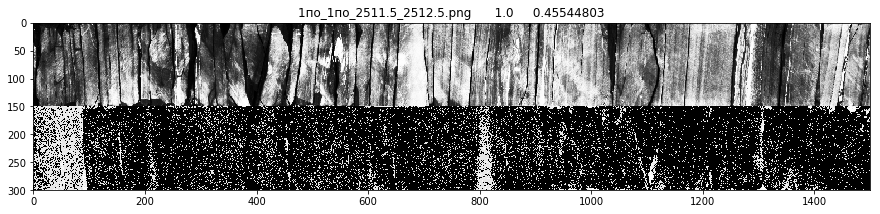

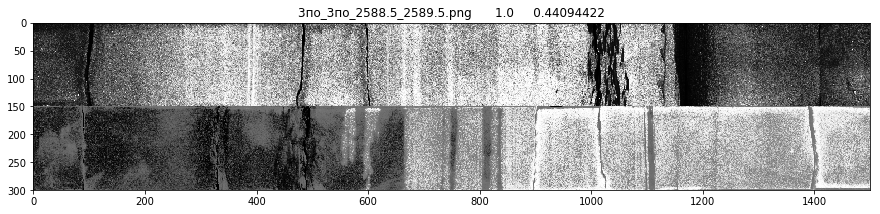

In [25]:
plot_images_predictions(test_ppl, 'fn')

## False positive

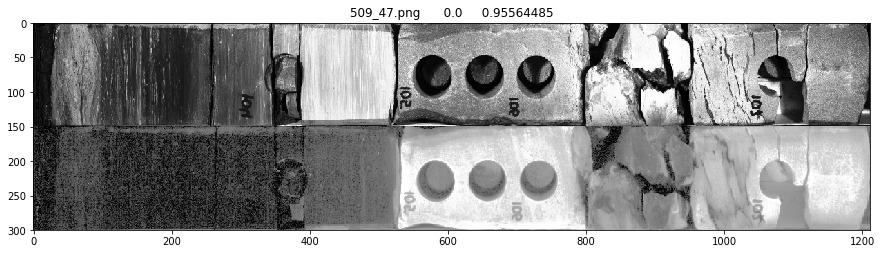

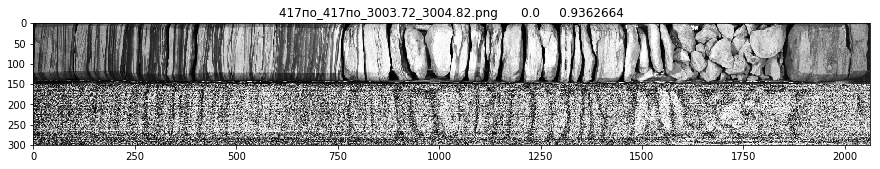

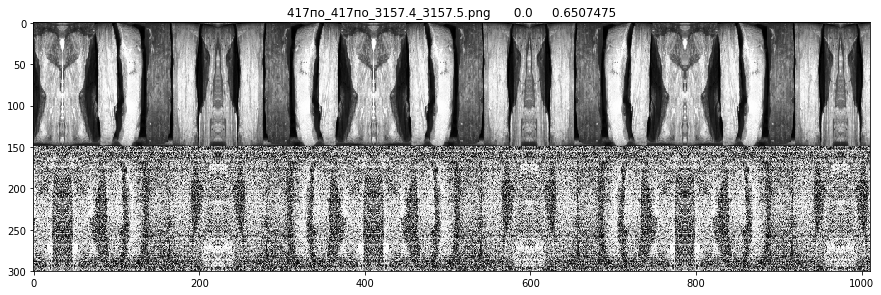

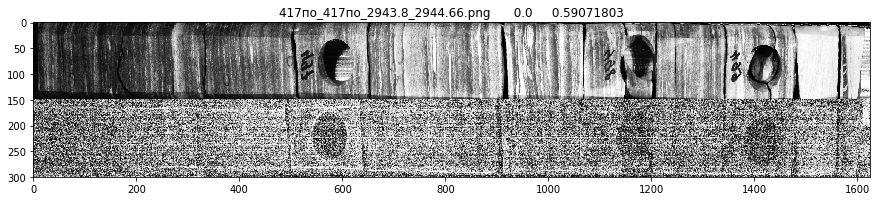

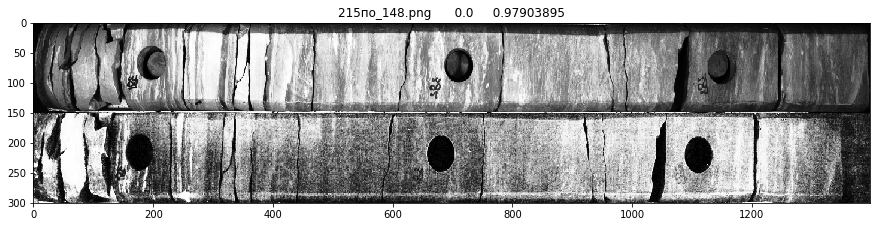

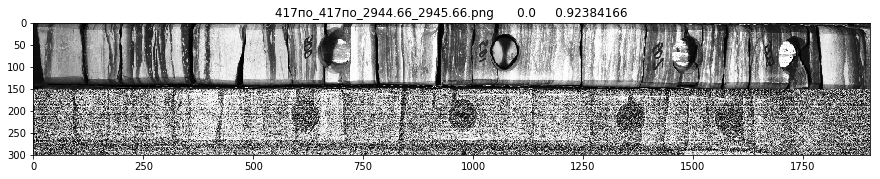

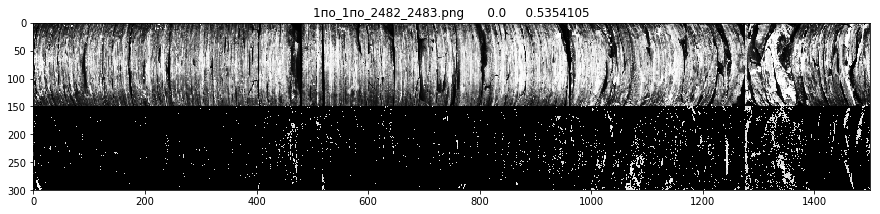

In [26]:
plot_images_predictions(test_ppl, 'fp')